# Case 21.7 Direct-Mail Fundraising

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Case study included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
import matplotlib.pylab as plt

from dmba import classificationSummary, gainsChart

DATA = Path('.').resolve().parent / 'data'

# Data preparation

In [2]:
# Load the data
fundraising_df = pd.read_csv(DATA / 'Fundraising.csv')
print(fundraising_df.TARGET_B.value_counts())
meanDonation = fundraising_df[fundraising_df.TARGET_B==1].TARGET_D.mean()
print('Mean donation by donors : ', meanDonation)

1    1560
0    1560
Name: TARGET_B, dtype: int64
Mean donation by donors :  12.99922435897436


In [3]:
# Prepare data for model building
fundraising_df.drop(columns=['Row Id', 'Row Id.', 'TARGET_D'], inplace=True)
fundraising_df.head()

,zipconvert_2,zipconvert_3,zipconvert_4,zipconvert_5,homeowner dummy,NUMCHLD,INCOME,gender dummy,WEALTH,HV,...,Icavg,IC15,NUMPROM,RAMNTALL,MAXRAMNT,LASTGIFT,totalmonths,TIMELAG,AVGGIFT,TARGET_B
0,0,1,0,0,1,1,5,1,9,1399,...,703,1,74,102.0,6.0,5.0,29,3,4.857143,1
1,1,0,0,0,1,1,1,0,7,698,...,463,4,46,94.0,12.0,12.0,34,6,9.400000,1
2,0,0,0,1,0,2,5,1,8,828,...,376,13,32,30.0,10.0,5.0,29,7,4.285714,1
3,0,0,0,1,1,1,3,0,4,1471,...,546,4,94,177.0,10.0,8.0,30,3,7.080000,0
4,0,1,0,0,1,1,4,0,8,547,...,432,7,20,23.0,11.0,11.0,30,6,7.666667,0


In [4]:
# Load the data for prediction
futureFundraising_df = pd.read_csv(DATA / 'FutureFundraising.csv')
futureFundraising_df.drop(columns=['Row Id.', 'TARGET_B', 'TARGET_D'], inplace=True)
futureFundraising_df.head(20)

,Row Id,zipconvert_2,zipconvert_3,zipconvert_4,zipconvert_5,homeowner dummy,NUMCHLD,INCOME,gender dummy,WEALTH,...,Icmed,Icavg,IC15,NUMPROM,RAMNTALL,MAXRAMNT,LASTGIFT,totalmonths,TIMELAG,AVGGIFT
0,1,0,1,0,0,1,1,1,1,8,...,470,452,3,42,92.0,29.0,15.0,17,8,15.333333
1,2,0,0,1,0,0,1,2,1,9,...,489,453,4,21,30.0,20.0,20.0,33,9,15.000000
2,3,0,0,0,1,0,1,1,0,4,...,412,376,10,61,220.0,35.0,25.0,31,9,24.444444
3,4,0,0,0,0,1,1,4,0,1,...,263,283,21,32,41.0,19.0,19.0,31,13,13.666667
4,5,0,0,1,0,1,1,7,1,9,...,793,850,1,47,46.0,10.0,10.0,28,8,5.750000
5,6,0,0,0,1,0,1,2,1,0,...,163,200,47,83,135.0,25.0,0.0,18,1,16.875000
6,7,0,1,0,0,0,1,3,0,9,...,370,380,12,15,20.0,20.0,20.0,33,6,20.000000
7,8,0,1,0,0,1,1,2,1,5,...,347,315,8,64,81.0,5.0,5.0,36,5,2.892857
8,9,0,0,1,0,1,1,7,1,9,...,1000,780,1,25,48.0,15.0,10.0,18,1,9.600000
9,10,0,0,0,1,1,1,4,0,9,...,343,404,6,12,15.0,15.0,15.0,33,6,15.000000


# Step 1: Partitioning
Partition the dataset into 60% training and 40% validation (set the seed to 12345).

In [5]:
X = fundraising_df.drop(columns=['TARGET_B'])
y = fundraising_df['TARGET_B']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=12345)

#### Define helper functions

In [6]:
def confusionMatrices(model, title):
    print(title + ' - training results')
    classificationSummary(train_y, model.predict(train_X))
    print(title + ' - validation results')
    classificationSummary(valid_y, model.predict(valid_X))

# Step 2: Model building
Follow the following steps to build, evaluate, and choose a model.

## Step 2.1:  Select classification tool and parameters
Run at least two classification models of your choosing.  Be sure NOT to use `TARGET_D` in your analysis. Describe the two models that you chose, with sufficient detail (method, parameters, variables, etc.) so that it can be replicated.

### Logistic regression

In [7]:
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)
confusionMatrices(logit_reg, 'Logistic regression')

Logistic regression - training results
Confusion Matrix (Accuracy 0.5673)

       Prediction
Actual   0   1
     0 476 446
     1 364 586
Logistic regression - validation results
Confusion Matrix (Accuracy 0.5737)

       Prediction
Actual   0   1
     0 349 289
     1 243 367


### Classification tree

In [8]:
classTree = DecisionTreeClassifier()
classTree.fit(train_X, train_y)

# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40], 
    'min_samples_split': [20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(2, 16)), 
    'min_samples_split': [96, 97, 98, 99, 100, 101, 102, 103], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

classTree = gridSearch.best_estimator_
confusionMatrices(classTree, 'Decision tree')

Initial score:  0.5747664884135473
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.005, 'min_samples_split': 20}
Improved score:  0.5747664884135473
Improved parameters:  {'max_depth': 2, 'min_impurity_decrease': 0.005, 'min_samples_split': 96}
Decision tree - training results
Confusion Matrix (Accuracy 0.5855)

       Prediction
Actual   0   1
     0 647 275
     1 501 449
Decision tree - validation results
Confusion Matrix (Accuracy 0.5489)

       Prediction
Actual   0   1
     0 432 206
     1 357 253


### Bagging

In [9]:
# we use the classification tree as the base estimator
bagging = BaggingClassifier(classTree, max_samples=0.5, max_features=0.5)
bagging.fit(train_X, train_y)
confusionMatrices(bagging, 'Bagged Decision tree')

Bagged Decision tree - training results
Confusion Matrix (Accuracy 0.5844)

       Prediction
Actual   0   1
     0 644 278
     1 500 450
Bagged Decision tree - validation results
Confusion Matrix (Accuracy 0.5553)

       Prediction
Actual   0   1
     0 440 198
     1 357 253


### Adaboost

In [10]:
adaboost = AdaBoostClassifier(n_estimators=100, base_estimator=classTree)
adaboost.fit(train_X, train_y)
confusionMatrices(adaboost, 'Boosted decision tree')

Boosted decision tree - training results
Confusion Matrix (Accuracy 0.5855)

       Prediction
Actual   0   1
     0 647 275
     1 501 449
Boosted decision tree - validation results
Confusion Matrix (Accuracy 0.5489)

       Prediction
Actual   0   1
     0 432 206
     1 357 253


### Random forest

In [11]:
rfModel = RandomForestClassifier(max_features=3, min_samples_split=300, 
                                 random_state=0, n_estimators=100, criterion='entropy')
rfModel.fit(train_X, train_y)
confusionMatrices(rfModel, 'Random forest')

Random forest - training results
Confusion Matrix (Accuracy 0.6202)

       Prediction
Actual   0   1
     0 577 345
     1 366 584
Random forest - validation results
Confusion Matrix (Accuracy 0.5417)

       Prediction
Actual   0   1
     0 350 288
     1 284 326


### Linear discriminant analysis

In [12]:
ldaModel = LinearDiscriminantAnalysis()
ldaModel.fit(train_X, train_y)
confusionMatrices(ldaModel, 'Linear discriminant analysis')

Linear discriminant analysis - training results
Confusion Matrix (Accuracy 0.5652)

       Prediction
Actual   0   1
     0 477 445
     1 369 581
Linear discriminant analysis - validation results
Confusion Matrix (Accuracy 0.5753)

       Prediction
Actual   0   1
     0 350 288
     1 242 368


### Neural network

In [13]:
scaleInput = MinMaxScaler()
scaleInput.fit(train_X * 1.0)

neuralNet = MLPClassifier(hidden_layer_sizes=(10), activation='logistic', solver='lbfgs', max_iter=3000, 
                          random_state=1)
neuralNet.fit(scaleInput.transform(train_X), train_y)

print('Neural Network - training results')
classificationSummary(train_y, neuralNet.predict(scaleInput.transform(train_X)))
print('Neural Network - validation results')
classificationSummary(valid_y, neuralNet.predict(scaleInput.transform(valid_X)))

Neural Network - training results
Confusion Matrix (Accuracy 0.7222)

       Prediction
Actual   0   1
     0 630 292
     1 228 722
Neural Network - validation results
Confusion Matrix (Accuracy 0.5337)

       Prediction
Actual   0   1
     0 318 320
     1 262 348


## Step 2.2 Classification under asymmetric response and cost
What is the reasoning behind using weighted sampling to produce  a training set
with equal numbers of donors and non-donors?  Why not use a simple
random sample from the original dataset? 

In this data set, the cases of interest (the "1's") are fairly rare. Since 
sample sizes for training and validating models are limited by the 
algorithms, it is best to have fairly equal numbers of 0's and 1's to give 
the algorithm a good shot at finding out what distinguishes the two classes. 
Think of it this way - if you have 100 1's and 100 0's, adding another 800 0's
is not going to help nearly as much as adding 400 of each.

## Step 2.3 Calculate net profit
For each method, calculate the cumulative gains
of net profit for both the training and validation sets based on the actual response rate (5.1\%.)  Again, the expected donation, given that they are donors, is \\$13.00, and the total cost of each mailing is \\$0.68.  
(Hint: To calculate estimated net profit, we will need to undo the effects of the weighted sampling and calculate the net profit that would reflect the actual response distribution of 5.1\% donors and 94.9\% non-donors. To do this, divide each row's net profit by the oversampling weights applicable to the actual status of that row.  The oversampling weight for actual donors is 50\%/5.1\% = 9.8.  The oversampling weight for actual non-donors is 50\%/94.9\% = 0.53.)

The cost for each mailing is \\$0.68, donors give on average \\$13. This leads to a net profit of \\$13.00-\\$0.68 for donors and a net loss of \\$0.68 for non-donors. 

To take the oversampling into account, we need to adjust the net profit as follows:

Donors: 
$$ ($13.00-$0.68) \frac{5.1\%}{50\%} \approx $1.25664 $$
Non-donors:
$$ -$0.68 \frac{94.9\%}{50\%} \approx -$1.29064 $$

To calculate the lift of the net profit we can define the following function

## Step 2.4 Draw cumulative gains curves
Draw the different models' %each model's 
net profit cumulative gains curves for the validation set in a single plot (net profit on the $y$-axis, proportion of list or number mailed on the $x$-axis). Is there a model that dominates?

To calculate the gain of the net profit we can define the following function

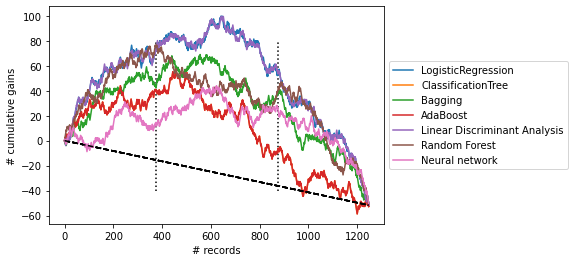

In [14]:
net_profit = [(13 - 0.68)*5.1/50 if respond == 1 else -0.68*94.9/50 for respond in valid_y]
net_profit = [(13 - 0.68)/9.8 if respond == 1 else -0.68/0.53 for respond in valid_y]

def addLiftChart(predict_proba, label, ax=None):
    df = pd.DataFrame(data={'prob': [p[1] for p in predict_proba], 'actual': net_profit})
    df = df.sort_values(by=['prob'], ascending=False)
    ax = gainsChart(df.actual, ax=ax, label=label)
    return ax

ax = addLiftChart(logit_reg.predict_proba(valid_X), 'LogisticRegression')
addLiftChart(classTree.predict_proba(valid_X), 'ClassificationTree', ax=ax)
addLiftChart(bagging.predict_proba(valid_X), 'Bagging', ax=ax)
addLiftChart(adaboost.predict_proba(valid_X), 'AdaBoost', ax=ax)
addLiftChart(ldaModel.predict_proba(valid_X), 'Linear Discriminant Analysis', ax=ax)
addLiftChart(rfModel.predict_proba(valid_X), 'Random Forest', ax=ax)
addLiftChart(neuralNet.predict_proba(scaleInput.transform(valid_X)), 'Neural network', ax=ax)

ax.vlines(x=[len(valid_y) * 0.3, len(valid_y) * 0.7], ymin=-40, ymax=80, linestyles='dotted')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Based on the lift charts, we would discard the AdaBoost, the Decision Tree classifier, Bagging and the neural network classifier. Logistic regression, linear discriminant analysis, and random forest perform well overall. These three classifiers perform initially comparable up to about 30% of the dataset (first vertical dashed line). The lift of the random forest classifier then drops until at about 80% (second vertical dashed line) the gains curve is joining the other two classifiers..

## Step 2.5: Select best model
From your answer in (2.4), what do you think is the "best" model?

Considering these results, we select either the logistic regression or the linear discriminant analysis model.

Your result will depend considerably on which of the classifier you chose and how you split your dataset into training and validation. Explore what happens when you vary the random seed in the dataset split. 

# Step 3: Testing
The file `FutureFundraising.csv` contains the attributes for future mailing candidates.  

## Step 3.6:
Using your "best" model from Step 2.5, which of these candidates do you predict as donors and non-donors? List them in descending order of the probability of being a donor. Starting at the top of this sorted list, roughly how far down would you go in a mailing campaign? 

We apply the logisitic regression model to the FutureFundraising.csv dataset.

In [15]:
mailingCandidates = pd.DataFrame({
    'Row Id': futureFundraising_df['Row Id'],
    'prediction': logit_reg.predict_proba(futureFundraising_df.drop(columns=['Row Id']))[:,1]
})
mailingCandidates = mailingCandidates.sort_values(by=['prediction'], ascending=False).reset_index(drop=True)
mailingCandidates.head(10)

,Row Id,prediction
0,1014,0.776190
1,722,0.775001
2,120,0.764403
3,56,0.760704
4,26,0.756007
5,778,0.754514
6,215,0.752654
7,165,0.748111
8,1263,0.742441
9,792,0.741868


Based on these results, you would want to mail at least 50% of the list - we are pretty confident of increasing profit to that point.  Mailing to more than 50% of the list seems counterproductive. Business considerations (e.g. resources available, aggressiveness of profit targets, etc.) could govern a choice around 30% range. 

Considering that we see variation of the gains charts with different splits into training and validation sets, also indictes that we should explore the analysis more to come up with a reasonable cutoff for mailing.